In [ ]:
# Mount Google Drive for dataset storage and checkpointing
from google.colab import drive
import os
import zipfile
import random

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings

# To suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install dependencies
!pip install timm

# Import packages
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # EfficientNet models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
# Unzip dataset
import os
import zipfile

zip_path = '/content/drive/MyDrive/400mal_600ben/400mal_600ben_224.zip'
extract_path = '/content/400mal_600ben'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

print("Unzipping...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzip complete!")

# Print directory structure
print("\nFile structure:")
for root, dirs, files in os.walk(extract_path):
    print(f" {root}")
    for f in files[:5]:
        print(f"   - {f}")

Unzipping...
Unzip complete!

File structure:
 /content/400mal_600ben
 /content/400mal_600ben/400mal_600ben_224
   - ISIC_2766683.jpg
   - ISIC_8300377.jpg
   - ISIC_5365617.jpg
   - ISIC_2232442.jpg
   - ISIC_8195604.jpg
 /content/400mal_600ben/__MACOSX
 /content/400mal_600ben/__MACOSX/400mal_600ben_224
   - ._ISIC_9625875.jpg
   - ._ISIC_0517460.jpg


# **1. DATA DECLARATION**

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 15
VERBOSE = True
PRINT_FREQ = 50

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths
CSV_PATH = '/content/drive/MyDrive/ISIC_2020_Training_GroundTruth.csv'
IMAGE_DIR = '/content/400mal_600ben/400mal_600ben_224'

Using device: cuda


#**2. DATASET & DATALOADER**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd

class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")
        try:
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

def prepare_data_with_test(csv_path, image_dir, test_size=0.1, val_size=0.1):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)][["image_name", "target"]].dropna()

    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["target"])
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"])

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_loader = DataLoader(JPEGDataset(train_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(JPEGDataset(val_df, image_dir, transform), batch_size=BATCH_SIZE)
    test_loader = DataLoader(JPEGDataset(test_df, image_dir, transform), batch_size=BATCH_SIZE)
    full_train_loader = DataLoader(JPEGDataset(train_val_df, image_dir, transform), batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df


#**3. MODEL TRAINING LOOP**

In [ ]:
#6. MODEL SETUP (OPTIMIZED)
def setup_model():
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

    return model, criterion, optimizer, scheduler

#7. MODEL TRAIN (OPTIMIZED)
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, path, epochs=EPOCHS):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Acc: {val_metrics['accuracy']:.4f} | AUC: {val_metrics['auc']:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            torch.save(model.state_dict(), path)
            print("Best model saved.")

# **4. EVALUATION**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

# ==================== 8. EVALUATION (OPTIMIZED) ====================
def evaluate_model(model, criterion, loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader.dataset), {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs),
        'fpr': roc_curve(all_labels, all_probs)[0],
        'tpr': roc_curve(all_labels, all_probs)[1]
    }

# **5. MAIN EXECUTION**

Step 1: Train model on train/val split


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/15 | Train Loss: 1.7979 | Val Loss: 1.4197 | Acc: 0.7600 | AUC: 0.8123
Best model saved.
Epoch 2/15 | Train Loss: 0.4218 | Val Loss: 1.2879 | Acc: 0.7500 | AUC: 0.8058
Best model saved.
Epoch 3/15 | Train Loss: 0.1043 | Val Loss: 1.3564 | Acc: 0.7300 | AUC: 0.8106
Epoch 4/15 | Train Loss: 0.0990 | Val Loss: 1.3460 | Acc: 0.7500 | AUC: 0.8163
Epoch 5/15 | Train Loss: 0.0827 | Val Loss: 1.3959 | Acc: 0.7500 | AUC: 0.8067
Epoch 6/15 | Train Loss: 0.0525 | Val Loss: 1.3269 | Acc: 0.7500 | AUC: 0.8117
Epoch 7/15 | Train Loss: 0.0451 | Val Loss: 1.3099 | Acc: 0.7600 | AUC: 0.8154
Epoch 8/15 | Train Loss: 0.0602 | Val Loss: 1.3105 | Acc: 0.7400 | AUC: 0.8175
Epoch 9/15 | Train Loss: 0.0624 | Val Loss: 1.3852 | Acc: 0.7600 | AUC: 0.8137
Epoch 10/15 | Train Loss: 0.0633 | Val Loss: 1.3905 | Acc: 0.7600 | AUC: 0.8167
Epoch 11/15 | Train Loss: 0.0504 | Val Loss: 1.3777 | Acc: 0.7500 | AUC: 0.8100
Epoch 12/15 | Train Loss: 0.0586 | Val Loss: 1.3556 | Acc: 0.7500 | AUC: 0.8131
Epoch 13/15 |

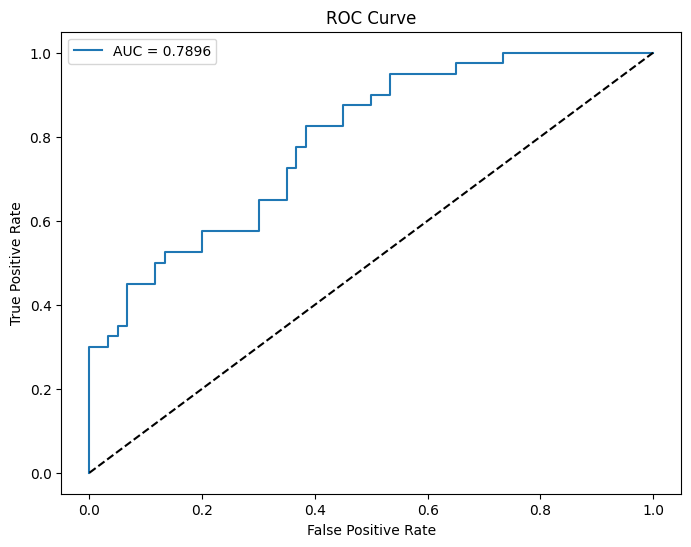

CPU times: user 4min 42s, sys: 2.65 s, total: 4min 45s
Wall time: 1min 32s


In [ ]:
%%time
train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

MODEL_LOAD_PATH = '/content/drive/MyDrive/efficientnet_model_Minh.pth'

print("Step 1: Train model on train/val split")
model, criterion, optimizer, scheduler = setup_model()
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, MODEL_LOAD_PATH)

print("Step 2: Retrain on full train + val set")
model, criterion, optimizer, scheduler = setup_model()
train_model(model, criterion, optimizer, scheduler, full_train_loader, val_loader, MODEL_LOAD_PATH)

print("Step 3: Evaluate on test set")
model.load_state_dict(torch.load(MODEL_LOAD_PATH))
test_loss, test_metrics = evaluate_model(model, criterion, test_loader)

print("\nFinal Test Results")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision:{test_metrics['precision']:.4f}")
print(f"Recall:   {test_metrics['recall']:.4f}")
print(f"AUC:      {test_metrics['auc']:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(test_metrics['fpr'], test_metrics['tpr'], label=f'AUC = {test_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# plt.savefig('/content/drive/MyDrive/efficientnet_roc_curve.png')
plt.show()


# **6. TUNING**

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.0 MB/s eta 0:00:00


In [ ]:
%%time
def objective(trial):
    # hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 0, 1e-4)

    # Setup model with current trial's hyperparams
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train for 5 epochs for quick evaluation
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
    return val_metrics["auc"]

study = optuna.create_study(direction="maximize")  # maximize AUC
study.optimize(objective, n_trials=10)

print("\nBest Trial:")
print(study.best_trial)

[I 2025-06-25 03:31:33,171] A new study created in memory with name: no-name-4a92a496-0613-4fd9-b7fd-2da7b57bfb53
[I 2025-06-25 03:31:43,971] Trial 0 finished with value: 0.6297916666666667 and parameters: {'learning_rate': 2.637162535143306e-05, 'dropout': 0.33010168330774203, 'weight_decay': 9.53044564107175e-05}. Best is trial 0 with value: 0.6297916666666667.
[I 2025-06-25 03:31:54,478] Trial 1 finished with value: 0.8102083333333333 and parameters: {'learning_rate': 0.00019770851064535076, 'dropout': 0.20296749847856202, 'weight_decay': 4.9374457947537854e-05}. Best is trial 1 with value: 0.8102083333333333.
[I 2025-06-25 03:32:06,262] Trial 2 finished with value: 0.8095833333333333 and parameters: {'learning_rate': 0.00024053507614413424, 'dropout': 0.3155145788104121, 'weight_decay': 2.6598521710793068e-05}. Best is trial 1 with value: 0.8102083333333333.
[I 2025-06-25 03:32:17,349] Trial 3 finished with value: 0.7960416666666666 and parameters: {'learning_rate': 0.0001851724350


Best Trial:
FrozenTrial(number=1, state=1, values=[0.8102083333333333], datetime_start=datetime.datetime(2025, 6, 25, 3, 31, 43, 972374), datetime_complete=datetime.datetime(2025, 6, 25, 3, 31, 54, 478884), params={'learning_rate': 0.00019770851064535076, 'dropout': 0.20296749847856202, 'weight_decay': 4.9374457947537854e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0005, log=True, low=1e-05, step=None), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'weight_decay': FloatDistribution(high=0.0001, log=False, low=0.0, step=None)}, trial_id=1, value=None)
CPU times: user 6min 41s, sys: 1.94 s, total: 6min 43s
Wall time: 1min 48s


# **7. RETRAIN WITH BEST PARAMS**

🔧 Step 1: Training with best hyperparameters on train/val split
Epoch 1/15 | Train Loss: 2.2519 | Val Loss: 1.3106 | Acc: 0.7100 | AUC: 0.7938
Best model saved!
Epoch 2/15 | Train Loss: 0.6280 | Val Loss: 1.4706 | Acc: 0.7100 | AUC: 0.7892
Epoch 3/15 | Train Loss: 0.2694 | Val Loss: 1.4210 | Acc: 0.7700 | AUC: 0.8204
Epoch 4/15 | Train Loss: 0.2257 | Val Loss: 1.3487 | Acc: 0.7600 | AUC: 0.8310
Epoch 5/15 | Train Loss: 0.1239 | Val Loss: 1.3009 | Acc: 0.7600 | AUC: 0.8385
Best model saved!
Epoch 6/15 | Train Loss: 0.1213 | Val Loss: 1.3432 | Acc: 0.7400 | AUC: 0.8292
Epoch 7/15 | Train Loss: 0.0888 | Val Loss: 1.3317 | Acc: 0.7400 | AUC: 0.8348
Epoch 8/15 | Train Loss: 0.0857 | Val Loss: 1.3982 | Acc: 0.7400 | AUC: 0.8290
Epoch 9/15 | Train Loss: 0.0814 | Val Loss: 1.3717 | Acc: 0.7400 | AUC: 0.8317
Epoch 10/15 | Train Loss: 0.0978 | Val Loss: 1.3460 | Acc: 0.7400 | AUC: 0.8342
Epoch 11/15 | Train Loss: 0.1182 | Val Loss: 1.3237 | Acc: 0.7400 | AUC: 0.8362
Epoch 12/15 | Train Loss: 0.1

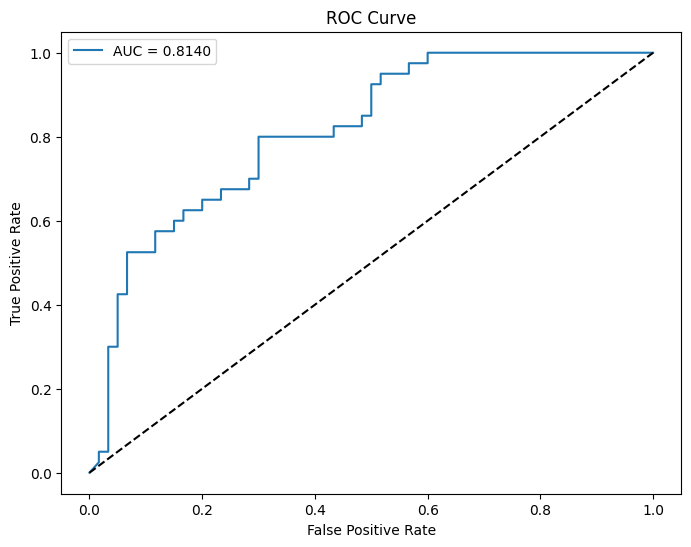

CPU times: user 4min 45s, sys: 2.67 s, total: 4min 47s
Wall time: 1min 20s


In [ ]:
%%time
# ==================== CUSTOM SETUP WITH BEST PARAMS ====================
def setup_model_with_custom_params(lr, dropout, weight_decay):
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1, drop_rate=dropout)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

    return model, criterion, optimizer, scheduler


# ==================== TRAINING WITH VALIDATION + SAVE BEST ====================
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, save_path, epochs=EPOCHS):
    best_val_loss = float('inf')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        val_loss, val_metrics = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Acc: {val_metrics['accuracy']:.4f} | AUC: {val_metrics['auc']:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved!")

# ==================== EXECUTION WITH BEST PARAMS ====================

# Get best hyperparameters from Optuna study
best_params = study.best_trial.params
MODEL_SAVE_PATH = '/content/drive/MyDrive/efficientnet_model_Minh.pth'

# Step 1: Prepare data
train_loader, val_loader, test_loader, full_train_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# Step 2: Train on train/val split
print("Step 1: Training with best hyperparameters on train/val split")
model, criterion, optimizer, scheduler = setup_model_with_custom_params(
    lr=best_params['learning_rate'],
    dropout=best_params['dropout'],
    weight_decay=best_params['weight_decay']
)
train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, save_path=MODEL_SAVE_PATH)

# Step 3: Retrain on full train+val
print("\nStep 2: Retraining on full train + val set")
model, criterion, optimizer, scheduler = setup_model_with_custom_params(
    lr=best_params['learning_rate'],
    dropout=best_params['dropout'],
    weight_decay=best_params['weight_decay']
)
train_model(model, criterion, optimizer, scheduler, full_train_loader, val_loader, save_path=MODEL_SAVE_PATH)

# Step 4: Evaluate
print("\n Step 3: Evaluate on test set")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_metrics = evaluate_model(model, criterion, test_loader)

print("\n Final Test Results (With Best Hyperparameters)")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision:{test_metrics['precision']:.4f}")
print(f"Recall:   {test_metrics['recall']:.4f}")
print(f"AUC:      {test_metrics['auc']:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(test_metrics['fpr'], test_metrics['tpr'], label=f'AUC = {test_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
